# Lab 1: Probability & Descriptive Statistics

## Instructions

Open in Google Colab: [Link](https://colab.research.google.com/drive/1JLABtp6OJUJHmODRHpQ9FQXovp73na_9?usp=share_link)

Alternatively, copy and paste the code below into RStuido Desktop or RStudio Cloud.

Finish Quiz for Lab 1 on Canvas.

Focus: explore core descriptive statistics and dependence concepts using simple synthetic data.

You will:

- Examine independence & correlation
- Compare skewed and roughly normal distributions
- Compute mean, variance, sd, skewness, kurtosis
- Compare biased vs unbiased variance estimators
- Simulate a high-correlation (ρ = 0.90) two-asset return setting
- Study sampling distributions of asset and portfolio means

## Datasets

Synthetic generators used:

- Right-skewed transaction values (log-normal)and approx. normal reference sample
- Two correlated asset return series (ρ = 0.90) for sampling exercises

Run each cell sequentially. Read the comments carefully.

In [1]:
# -------- Setup: packages --------
# Unified required package list
pkgs <- c("tidyverse", "ggsci", "moments", "knitr", "kableExtra")
missing <- setdiff(pkgs, rownames(installed.packages()))
if (length(missing) > 0) install.packages(missing)

# Load all packages (silently)
invisible(lapply(pkgs, library, character.only = TRUE))

# Set default options for figures in Jupyter Notebook
options(repr.plot.width = 12, repr.plot.height = 4)  # wider default figures

message("\n Setup complete (packages loaded: ", paste(pkgs, collapse = ", "), ").")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4          ✔ readr     2.1.5     
✔ forcats   1.0.0          ✔ stringr   1.5.1     
✔ ggplot2   3.5.2.9002     ✔ tibble    3.3.0     
✔ lubridate 1.9.4          ✔ tidyr     1.3.1     
✔ purrr     1.1.0          
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows



 Setup complete (packages loaded: tidyverse, ggsci, moments, kni

## Independence vs. Zero Correlation

Independence means no influence between events, while correlation measures linear relationship strength. 

Independence implies zero correlation, but zero correlation does not imply independence.

E.g., $X$ and $Y = X^2$ have zero correlation but are not independent.

In [2]:
# ---- Zero Correlation but NOT Independence: Y = X^2 ----
# Idea: X ~ N(0,1); define Y = X^2.  Then cor(X,Y) ~ 0 (symmetry cancels linear relation),
# yet Y is a deterministic function of X so they are NOT independent.

set.seed(2025)
n <- 5000
X <- rnorm(n)
Y <- X^2
r_xy <- cor(X, Y)
cat(sprintf("Sample correlation cor(X, Y=X^2) = %.4f (near 0)\n", r_xy))

Sample correlation cor(X, Y=X^2) = 0.0198 (near 0)


We got $\rho_{X,Y}=0.0198$. It seems to be close to zero, but we need a statistical test to confirm this formally. 

→ Test for significance of the correlation coefficient

In [3]:
cor.test(X, Y)


	Pearson's product-moment correlation

data:  X and Y
t = 1.4027, df = 4998, p-value = 0.1608
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.007887062  0.047529726
sample estimates:
       cor 
0.01983657 


--------------------------------------------------------------------------------

💡 **Q: Based on the output of `cor.test`, what is the p-value for the correlation test? What can you conclude about the correlation between the two variables?** Are $X$ and $Y$ independent? Write your answer in the cell below.


A: [Type your answer here]

Distinguish the two expressions:

- correlation coefficient equals zero ❌
- correlation coefficient (statistically) indifferent from zero ✅

--------------------------------------------------------------------------------

Now let's visualize $Y=X^2$ by plotting the scatter plot.

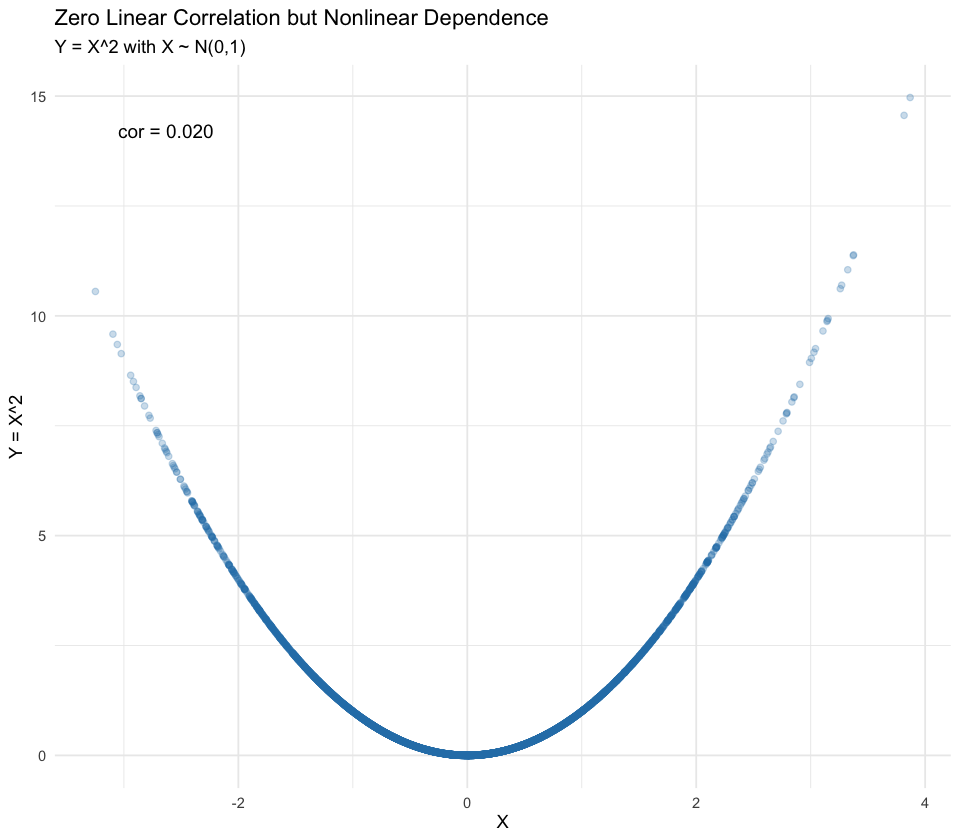

In [4]:
library(ggplot2)
options(repr.plot.width = 8, repr.plot.height = 7)
scatter_df <- data.frame(X = X, Y = Y)
p1 <- ggplot(scatter_df, aes(X, Y)) +
  geom_point(alpha = 0.25, color = '#2c7fb8') +
  annotate('text', x = min(X)+0.2, y = max(Y)*0.95,
           label = paste0('cor = ', sprintf('%.3f', r_xy)),
           hjust = 0, size = 4) +
  labs(title = 'Zero Linear Correlation but Nonlinear Dependence',
       subtitle = 'Y = X^2 with X ~ N(0,1)',
       x = 'X', y = 'Y = X^2') +
  theme_minimal()
print(p1)

The following figure shows the scatter plot of two assets with various correlation coefficients.

<img src="https://drive.google.com/thumbnail?id=1nF_8ajDVk6tXjIgnRFBd4jc4Ddl9L8rI&sz=w1000" alt="" style="display: block; margin-right: auto; margin-left: auto; zoom:80%;" />

## Descriptive Statistics on Asset Returns

In [5]:
# ---- Load Asset Returns Data ----
asset_df <- read_csv("https://raw.githubusercontent.com/my1396/FIN5005-Fall2025/refs/heads/main/data/asset_returns.csv")
print("Preview: first 6 rows of asset returns data frame:")
head(asset_df) %>% round(2)

[1] "Preview: first 6 rows of asset returns data frame:"


Asset_A,Asset_B,Asset_C
<dbl>,<dbl>,<dbl>
17.89,4.31,9.94
10.30,4.17,10.55
20.87,14.16,6.61
18.21,22.33,9.58
17.49,2.23,10.23
29.87,15.72,8.97


We define a summary statistics function to compute the statistics of interest.

In [6]:
quick_summary <- function(x) {
  # Function to compute basic descriptive statistics
  data.frame(
    n = length(x),
    mean = mean(x),
    sd = sd(x),
    var = var(x),
    skewness = moments::skewness(x),
    kurtosis = moments::kurtosis(x),
    row.names = NULL
  )
}

The summary statistic table is generated as follows:

In [7]:
lapply(asset_df, quick_summary) %>%
    do.call(rbind, .) %>%
    kable(digits = 2, caption = "Descriptive Statistics of Asset Returns")



Table: Descriptive Statistics of Asset Returns

|        |     n|  mean|   sd|   var| skewness| kurtosis|
|:-------|-----:|-----:|----:|-----:|--------:|--------:|
|Asset_A | 10000| 20.14| 4.82| 23.24|    -0.10|     3.15|
|Asset_B | 10000|  8.50| 4.44| 19.71|     1.71|     9.19|
|Asset_C | 10000|  9.99| 1.01|  1.01|    -0.85|     3.50|

Plot the histograms of the asset returns to visualize their distributions.

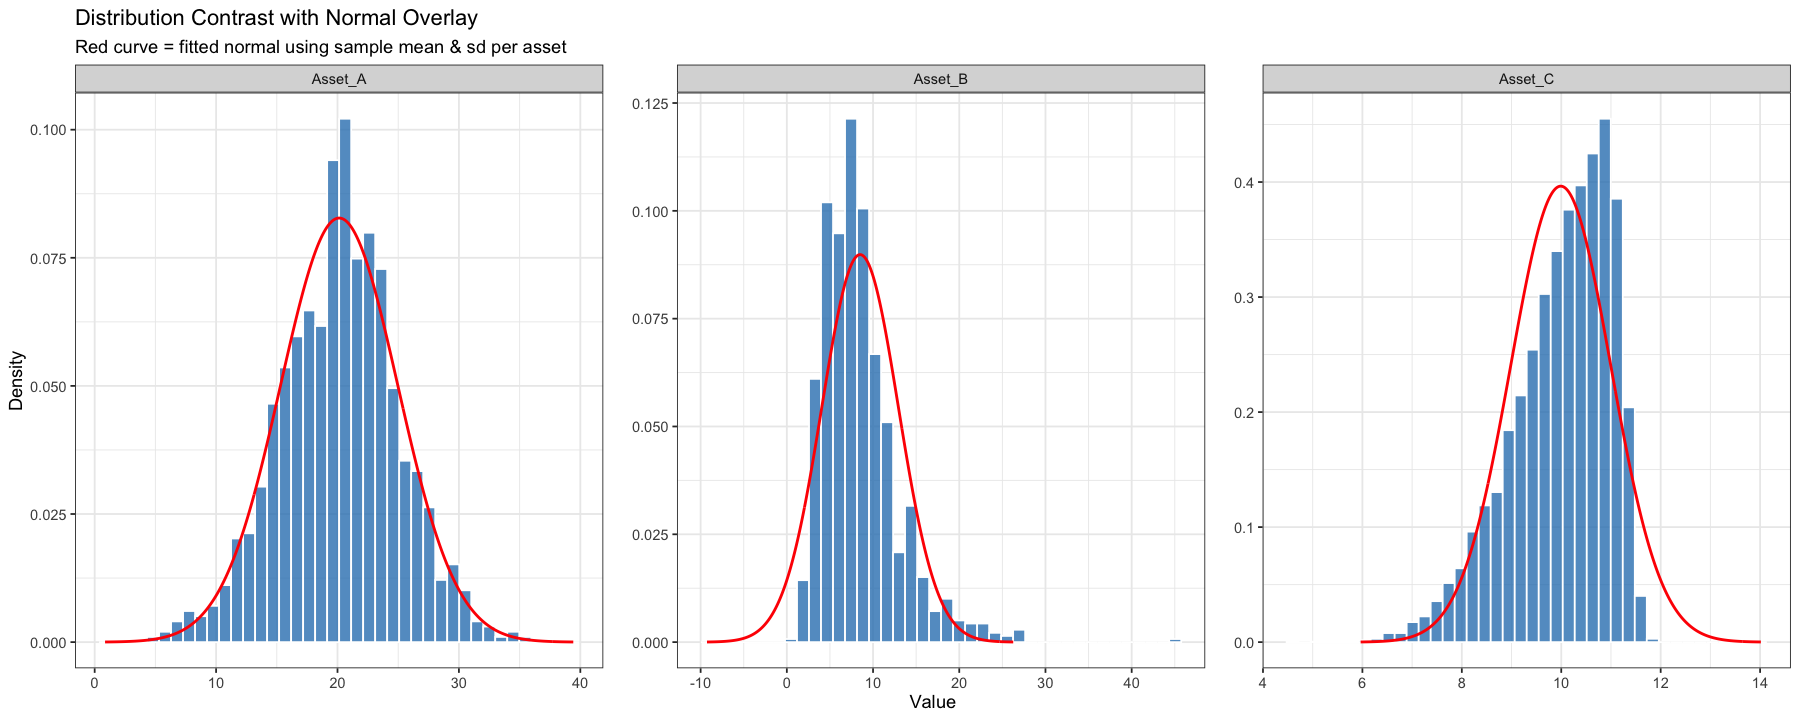

In [8]:
# ---- Visualization: Histograms with Normal Density Overlay ----
# Convert to long form
combined <- asset_df %>% pivot_longer(cols = everything(), names_to = "type", values_to = "value")

# Compute per-type mean & sd and create normal curve points
norm_params <- combined %>% group_by(type) %>% summarise(mu = mean(value), sigma = sd(value), .groups = 'drop')

norm_curve <- norm_params %>% group_by(type) %>% do({
  mu <- .$mu; sigma <- .$sigma
  x <- seq(mu - 4*sigma, mu + 4*sigma, length.out = 400)
  tibble(value = x, density = dnorm(x, mu, sigma))
})

options(repr.plot.width = 15, repr.plot.height = 6)

ggplot(combined, aes(value)) +
  geom_histogram(aes(y = after_stat(density)), bins = 40, fill = "#3182bd", alpha = 0.8, color = "white") +
  geom_line(data = norm_curve, aes(value, density), color = "red", linewidth = 0.8) +
  facet_wrap(~ type, scales = "free", nrow = 1) +
  labs(title = "Distribution Contrast with Normal Overlay",
       subtitle = "Red curve = fitted normal using sample mean & sd per asset",
       x = "Value", y = "Density") +
  theme(panel.spacing.x = unit(1.2, "lines"))

--------------------------------------------------------------------------------

💡 **Q: Answer the following questions based on the summary statistics and the distribution plots:**

- Which asset has the highest mean return?
- Which asset is the most risky? and which one has the most stable returns?
- Which asset shows the positive skewness and what does it mean?
- If an investor prefers assets with low risk and return distributions with tails close to normal, which asset is most appropriate?
- Based on mean and standard deviation, which asset has the best risk–return trade-off (highest mean per unit of risk)?


A: [Type your answer here]


---

## Large Sample Gives More Accurate Estimates

We have a variable $X\sim N(0,5^2).$

Normal distribution notation: $X\sim N(\mu, \sigma^2)$ means that $X$ is normally distributed with mean $\mu$ and variance $\sigma^2.$

The second parameter is the variance, **NOT** the standard deviation.

Now we draw random samples of size 5, 10, 10, ... until 5000 from this distribution and compute the sample mean and standard deviation for each sample.

For each sample, we compute the biased and unbiased sample variance

- The biased sample variance is computed as $$\frac{1}{n}\sum_{i=1}^n (x_i - \bar{x})^2.$$
- The unbiased sample variance is computed as $$\frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})^2$$

In [9]:
# ---- Simulation: Sample vs Population variance ----
set.seed(2025)  # for reproducibility
true_var <- 25  # sd^2 with sd=5, true population variance
sample_sizes <- c(5, 10, 20, 50, 100, 250, 500, 1000, 5000) # varying sample sizes from 5 to 500
results <- lapply(sample_sizes, function(n){
  x <- rnorm(n, mean = 0, sd = 5)
  data.frame("sample_size" = n, "var_biased" = mean((x - mean(x))^2), "var_unbiased" = var(x))
}) %>% dplyr::bind_rows()
cat('Variance estimators: var_n (biased, divide by n) vs var_n1 (unbiased, divide by n-1).\n')
results

Variance estimators: var_n (biased, divide by n) vs var_n1 (unbiased, divide by n-1).


sample_size,var_biased,var_unbiased
<dbl>,<dbl>,<dbl>
5,4.262707,5.328384
10,14.832929,16.481032
20,33.210505,34.958426
50,25.332410,25.849398
100,24.957059,25.209150
250,22.936725,23.028840
500,25.862610,25.914439
1000,25.574182,25.599782
5000,25.301658,25.306719


--------------------------------------------------------------------------------

💡 **Q: Based on the variance estimates for different sample sizes:**

- **As the sample size increases, how do the sample variance estimates compare to the true variance $25$?**
- **Does the sample variance converge to the true variance as the sample size increases?**
- **What is the difference between the biased and unbiased sample variance estimators?**

A: [Type your answer here]

--------------------------------------------------------------------------------

In [ ]:
# ---- Plot: Convergence of variance estimators ----

results_long <- results %>%
  tidyr::pivot_longer(var_biased:var_unbiased, names_to = "estimator", values_to = "value") %>%
  dplyr::mutate(estimator = dplyr::recode(estimator, var_n = "Divide by n", var_n1 = "Divide by n-1"))

options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(results_long, aes(sample_size, value, color = estimator)) +
  geom_line() +
  geom_point() +
  scale_color_npg() +
  geom_hline(yintercept = true_var, linetype = "dashed") +
  xlim(c(0,500)) +
  labs(title = "Convergence of Variance Estimators", y = "Estimated variance", x = "Sample size")


## Correlated Asset Returns
We will simulate repeated samples of two (correlated) asset return series and compare the sampling distributions of their sample means and the distribution of the portfolio mean (equal weights).

In [10]:
# ---- Load Correlated Asset Returns Data ----
X_demo <- read_csv("https://raw.githubusercontent.com/my1396/FIN5005-Fall2025/refs/heads/main/data/correlated_asset_returns.csv")
colnames(X_demo) <- c("Asset_A", "Asset_B")  # Rename columns for clarity
head(X_demo) %>% round(4)

Asset_A,Asset_B
<dbl>,<dbl>
0.0129,0.0351
0.0012,0.0094
0.0160,0.0130
0.0259,0.0550
0.0079,0.0147
-0.0028,-0.0234


In [ ]:
emp_cor <- cor(X_demo)
emp_cor

Plot the scatter plot of the two asset returns to visualize their relationship.

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 7)
ggplot(X_demo, aes(Asset_A, Asset_B)) +
  geom_point(alpha = 0.35, color = '#1b7837') 

--------------------------------------------------------------------------------

💡**Q: What is the correlation between the two asset returns? How do their prices move together?**

A: [Type your answer here]

--------------------------------------------------------------------------------

#### <span class="env-green"><i class="codicon codicon-rocket" style="font-size:2em; "></i> Exercise</span>

Following the steps below, you will compute the mean and standard deviation of the two asset returns, construct a portfolio, and analyze its properties.

Step 1: Calculate the standard deviation of Asset A and B returns, respectively. 

Step 2: Construct a equally weighted portfolio of the two assets. Calculate the portfolio returns.
$$
E[r_p] = \frac{1}{2} (E[r_A] + E[r_B])
$$

Step 3: Calculate the standard deviation of the portfolio returns, $\text{sd}(r_p)$.

Step 4: Calculate the average of the volatility of Asset A and B (using results in Step 1). Compare it with the volatility of the portfolio returns.

### Reflection

How does correlation between assets influence the portfolio mean's variability? Write 3–4 sentences interpreting for a diversified vs concentrated investment decision.